In [350]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
import commands

In [4]:
N = 6
t = 100000
deltar = 10
policy = 'DCNC'
V = 1.0

Mean queue length sum =  199247.8841
Mean cost =  224.05375


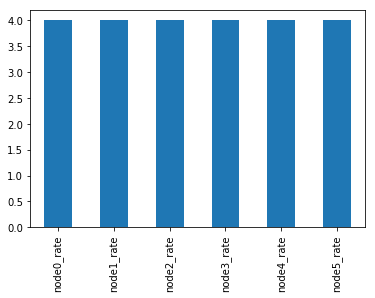

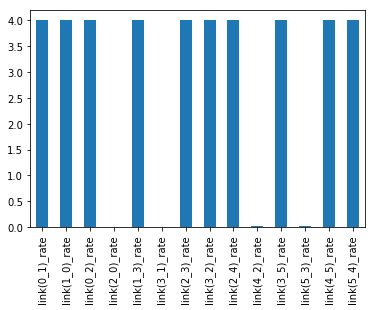

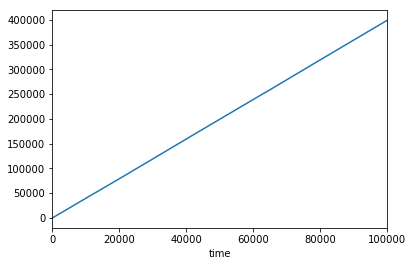

In [5]:
schedule, queue, cost = test(N, t, deltar, policy, V)

In [160]:
def test(N, t, deltar, policy, V):
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)

    commands.getstatusoutput(sim_command)    
    
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    cost = pd.DataFrame.from_csv(output_dir + 'cost_' + sim_instance + '.csv')
    
    node_rate_columns = schedule.columns[[('rate' in x and 'node' in x) for x in schedule.columns]]
    link_rate_columns = schedule.columns[[('rate' in x and 'link' in x) for x in schedule.columns]]

    #plt.figure()
    #schedule[node_rate_columns].head(1000).plot()
    
    plt.figure()
    schedule[node_rate_columns].mean().plot(kind='bar')
    plt.title('V = ' + str(V))
    
    plt.figure()
    schedule[link_rate_columns].mean().plot(kind='bar')
    
    plt.figure()
    queue.sum(axis=1).plot()
    
    print 'Mean queue length sum = ', queue.sum(axis=1).mean()
    print 'Mean cost = ', cost.sum(axis=1).mean()
    #print queue.mean()
    return schedule, queue, cost

In [161]:
N = 6
t = 100000
deltar = 10
V = 10.0
policy = 'ADCNC'

V =  1.0
Mean queue length sum =  6071.31613
Mean cost =  218.66034
V =  5.0
Mean queue length sum =  6718.94828
Mean cost =  177.09767
V =  10.0
Mean queue length sum =  7642.39609
Mean cost =  149.03223
V =  50.0
Mean queue length sum =  17211.94972
Mean cost =  102.49191
V =  100.0
Mean queue length sum =  24694.85414
Mean cost =  64.32222


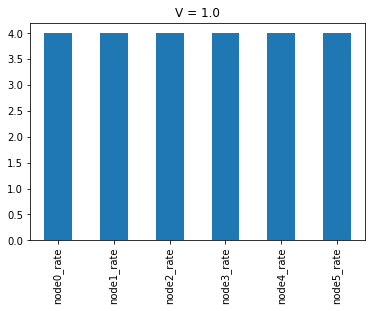

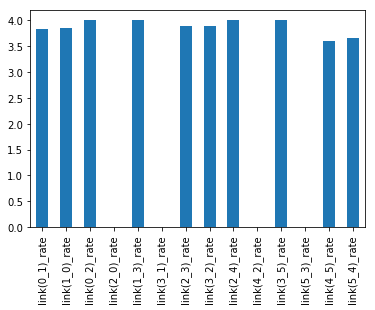

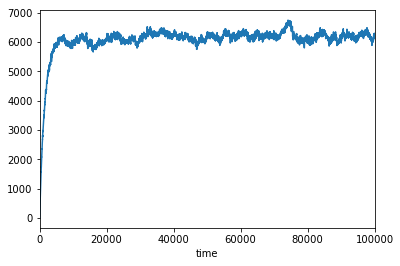

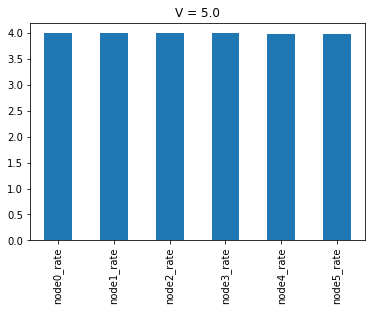

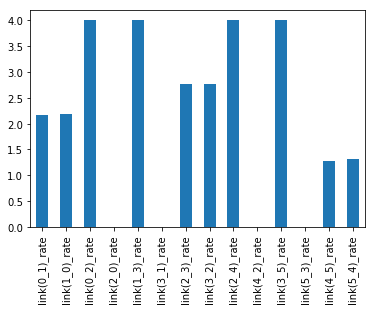

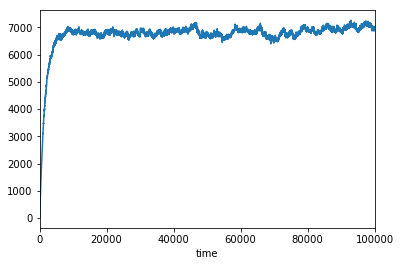

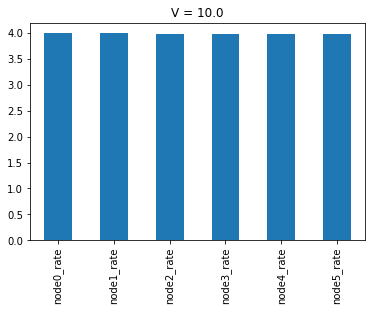

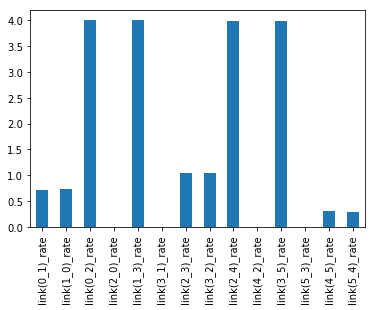

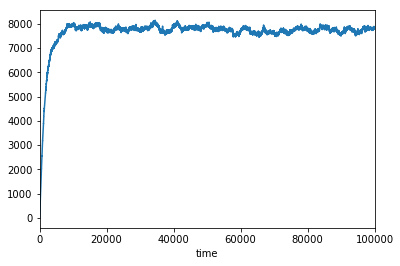

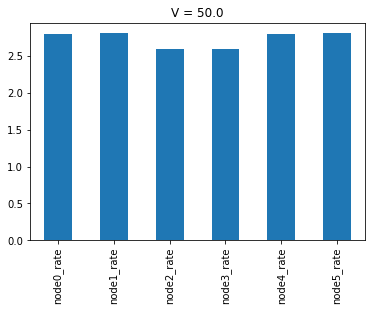

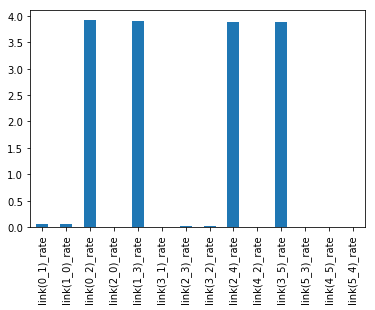

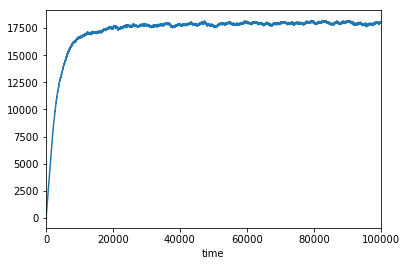

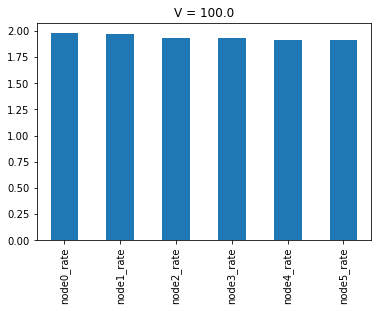

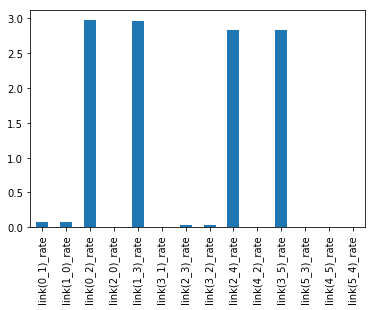

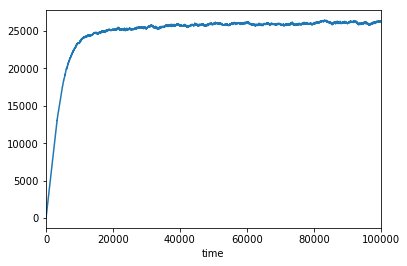

In [162]:
costs = []
queues = []
for V in [1.0, 5.0, 10.0, 50.0, 100.0]:
    print 'V = ', V
    schedule, queue, cost = test(N, t, deltar, policy, V)
    costs.append(cost.sum(axis=1).mean())
    queues.append(queue.sum(axis=1).mean())
    del schedule, queue, cost

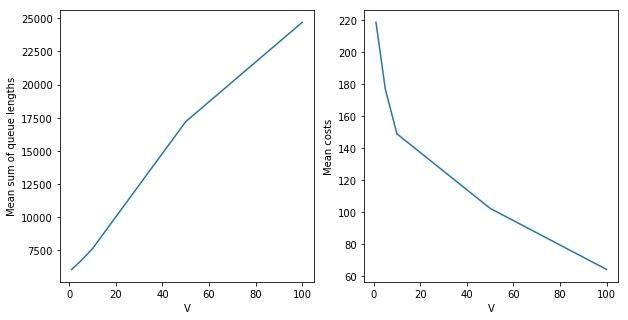

In [169]:
Vs = [1.0, 5.0, 10.0, 50.0, 100.0]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Vs, queues)
plt.xlabel('V')
plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
plt.plot(Vs, costs)
plt.xlabel('V')
plt.ylabel('Mean costs')

In [362]:
def rate_plot(schedule, V):
    rates = pd.DataFrame()
    for n in xrange(N):
        node = schedule.columns[['node'+str(n) in x for x in schedule.columns]]
        df = schedule[node].copy()
        df.loc[df['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_packet'] = None
        df = df.fillna(0)
        df = (df.groupby('node'+str(n)+'_packet').sum() / df.shape[0])[['node'+str(n)+'_rate']]
        df.index.name = ''
        if rates.empty:
            rates = df
        else:
            rates = rates.join(df, how='outer')

    rates = rates.sort_index(ascending=False)
    rates = rates.stack()
    rates = rates.unstack(0)
    
    link_rates = pd.DataFrame()
    for l in schedule.columns[['link' in x and 'rate' in x for x in schedule.columns]].str.strip('_rate'):
        link = schedule.columns[[l in x for x in schedule.columns]]
        df = schedule[link].copy()
        df.loc[df[l+'_reconfig'] > 0, l+'_packet'] = None
        df = df.fillna(0)
        df = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_rate']]
        if link_rates.empty:
            link_rates = df
        else:
            link_rates = link_rates.join(df, how='outer')

    link_rates = link_rates.sort_index(ascending=False)
    link_rates = link_rates.stack()
    link_rates = link_rates.unstack(0)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6));
    rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[0], colormap='nipy_spectral')
    axes[0].set_title('V = ' + str(V))
    link_rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[1], colormap='nipy_spectral')
    axes[1].set_title('V = ' + str(V))

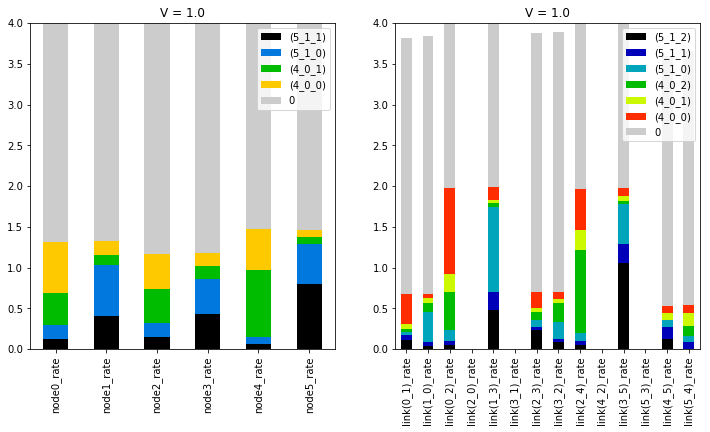

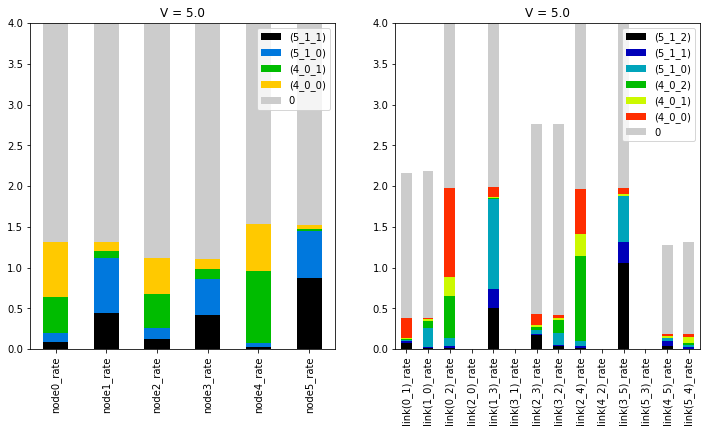

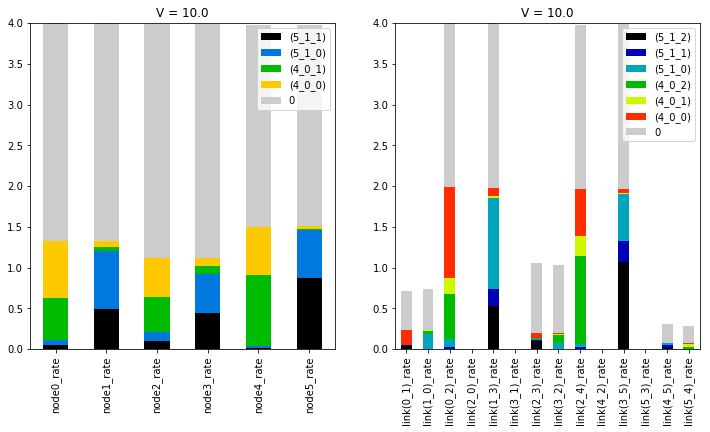

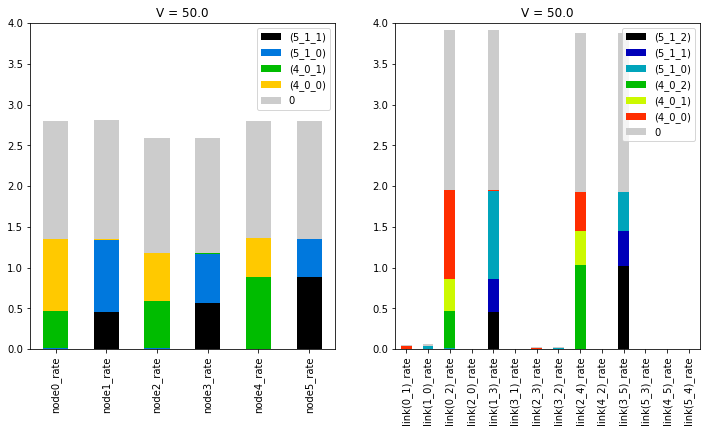

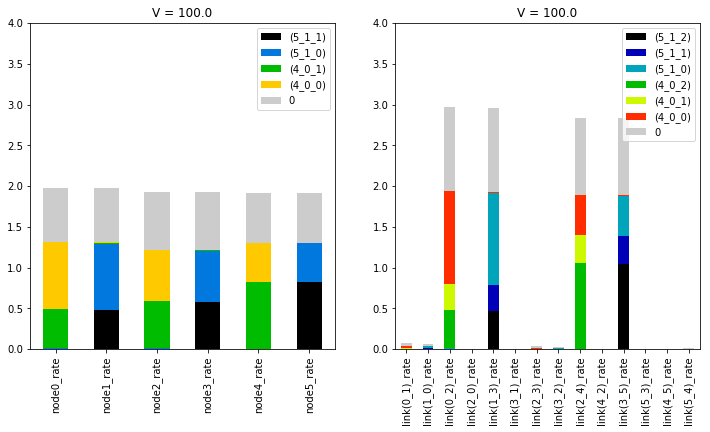

In [364]:
for V in Vs:
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, V)

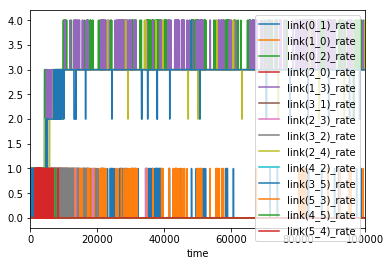

In [323]:
V = 100.0
output_dir = 'output/sim/'
sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')

link_rate_columns = schedule.columns[[('rate' in x and 'link' in x) for x in schedule.columns]]
schedule[link_rate_columns].plot()

In [325]:
l = schedule.columns[['link' in x and 'rate' in x for x in schedule.columns]].str.strip('_rate')[0]
link = schedule.columns[[l in x for x in schedule.columns]]
df = schedule[link].copy()
df.loc[df[l+'_reconfig'] > 0, l+'_packet'] = None
df = df.fillna(0)
df = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_rate']]

df.head()

,link(0_1)_rate
link(0_1)_packet,
0,0.02501
(4_0_0),0.03425
(4_0_1),0.00832
(4_0_2),0.00224


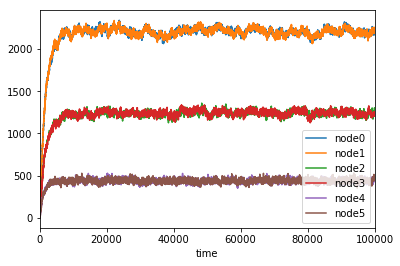

In [36]:
nodes=[]
for n in xrange(6):
    queue['node'+str(n)] = queue[queue.columns[[('node'+str(n) in x) for x in queue.columns]]].sum(axis=1)
    nodes.append('node'+str(n))
queue[nodes].plot()

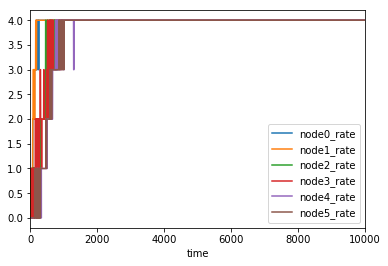

In [37]:
node_rate_columns = schedule.columns[[('rate' in x and 'node' in x) for x in schedule.columns]]
schedule[node_rate_columns].head(10000).plot()

In [12]:
schedule.columns

Index([u'node0_packet', u'node0_resource', u'node0_rate', u'node0_reconfig',
       u'node1_packet', u'node1_resource', u'node1_rate', u'node1_reconfig',
       u'node2_packet', u'node2_resource',
       ...
       u'link(10_8)_rate', u'link25_reconfig', u'link26_packet',
       u'link26_resource', u'link(9_10)_rate', u'link26_reconfig',
       u'link27_packet', u'link27_resource', u'link(10_9)_rate',
       u'link27_reconfig'],
      dtype='object', length=156)

In [14]:
node_rate_columns = schedule.columns[[('rate' in x and 'node' in x) for x in schedule.columns]]

In [20]:
queue.mean().sum()

768.2135000000001